# Primary notebook to visualize disturbance data

This notebook is the culmination of many other notebooks that creates complex
visualizations of the disturbance stack for fire, beetle, and drought data.

In [1]:
# Import packages and define file paths
import earthpy as et
from os import path
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from shapely import box
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio as rio
from rasterio.plot import plotting_extent
from matplotlib.patches import Patch
from skimage.measure import block_reduce
import pandas as pd

home = path.join(et.io.HOME, "GitHub", "visualize-forest-disturbance")

output_folder = path.join(et.io.HOME, "GitHub", "visualize-forest-disturbance", "data", "output")

home_tif = path.join(output_folder, "output_tifs")

forest_folder = path.join(home, "data", "input", "forest-disturbance-stack", "western-conus")

In [2]:
def summarize_by_1000_rows(df):
    """
    Summarizes the DataFrame by aggregating the percentages over every 1000 rows
    and stores these aggregated values with the first index of each summarized area.

    Parameters:
    df (pd.DataFrame): DataFrame containing 'Row' and 'Percent of 1s' columns.

    Returns:
    pd.DataFrame: DataFrame with summarized data.
    """
    # Determine the number of rows
    num_rows = df.shape[0]
    
    # Calculate the number of groups (each containing 1000 rows)
    num_groups = (num_rows + 999) // 1000
    
    # Initialize lists to hold summary data
    summarized_rows = []
    summarized_percentages = []
    
    # Process each group
    for group in range(num_groups):
        start_index = group * 1000
        end_index = min((group + 1) * 1000, num_rows)
        
        # Select the subset of the DataFrame
        subset = df.iloc[start_index:end_index]
        
        # Sum the percentages in this group
        total_percentage = subset['Percent of 1s'].sum()
        
        # Store the result with the first index of the group
        summarized_rows.append(int(df.iloc[start_index]['Row']))
        summarized_percentages.append(total_percentage / (end_index - start_index))
    
    # Create a summarized DataFrame
    summarized_df = pd.DataFrame({
        'Row': summarized_rows,
        'Percent of 1s': summarized_percentages
    })
    
    return summarized_df

In [3]:
# Open up all data to get metadata
fire_int_path = path.join(home_tif, 'fire_stack.tif')
with rio.open(fire_int_path) as src:
    print(src.dtypes)
    crs = src.crs
    bounds = src.bounds

('uint8',)


In [4]:
beetle_int_path = path.join(home_tif, 'beetle_stack.tif')
with rio.open(beetle_int_path) as src:
    print(src.dtypes)

('uint8',)


In [5]:
drought_int_path = path.join(home_tif, 'drought_stack.tif')
with rio.open(drought_int_path) as src:
    print(src.dtypes)

('uint8',)


In [6]:
all_int_path = path.join(forest_folder, "total_disturbances.tif")

In [9]:
# USFS ecoregions for visualization
USFS_ecoregions = gpd.read_file(path.join(home, "data", "input", "USFA", "S_USA.AdministrativeRegion", "S_USA.AdministrativeRegion.shp"))

regions = ['01', '02', '03', '04', '05', '06']
USFS_ecoregions_sel = USFS_ecoregions[USFS_ecoregions['REGION'].isin(regions)]
bbox = box(xmax=-102, xmin=-127.887457, ymax=50.938244, ymin=15.83326)
USFS_ecoregions_clip = USFS_ecoregions_sel.clip(bbox)

USFS_ecoregions_clip.boundary.plot()

In [11]:
# Load all arrays, create a mask to show areas with no data
with rio.open(fire_int_path) as src:
    fire_crs = src.crs
    fire_array = src.read(1)
    fire_extent = plotting_extent(src)
    fire_meta = src.profile
    fire_transofrm = src.transform

fire_orig = fire_array.copy()
fire_mask = fire_array != 255
fire_mask = fire_mask.astype(bool)
fire_array[fire_array == 255] = 0

USFS_reproj = USFS_ecoregions_clip.to_crs(fire_crs)

In [12]:
with rio.open(drought_int_path) as src:
    drought_array = src.read(1)
    drought_extent = plotting_extent(src)
    drought_meta = src.profile

drought_orig = drought_array.copy()
drought_array[drought_array == 255] = 0

In [13]:
with rio.open(beetle_int_path) as src:
    beetle_array = src.read(1)
    beetle_extent = plotting_extent(src)
    beetle_meta = src.profile

beetle_orig = beetle_array.copy()
beetle_array[beetle_array == 255] = 0

In [14]:
with rio.open(all_int_path) as src:
    all_array = src.read(1)
    all_extent = plotting_extent(src)
    all_meta = src.profile

all_orig = all_array.copy()
all_array[all_array == 255] = 0

In [15]:
#Simplify the data to make it easier to visualize 
aggregated_fire = block_reduce(fire_array, block_size=(100, 100), func=np.max)
aggregated_beetle = block_reduce(beetle_array, block_size=(100, 100), func=np.max)
aggregated_drought = block_reduce(drought_array, block_size=(100, 100), func=np.max)
aggregated_all = block_reduce(all_array, block_size=(100, 100), func=np.max)
aggregated_mask = block_reduce(fire_mask, block_size=(100, 100), func=np.max)

In [16]:
# Open up latitudinal analysis outputs
drought_lat_path = path.join(output_folder, "output_csvs", "drought_lat.csv")
fire_lat_path = path.join(output_folder, "output_csvs", "fire_lat.csv")
beetle_lat_path = path.join(output_folder, "output_csvs", "beetle_lat.csv")
all_lat_path = path.join(output_folder, "output_csvs", "all_lat.csv")

drought_lat = pd.read_csv(drought_lat_path)
fire_lat = pd.read_csv(fire_lat_path)
beetle_lat = pd.read_csv(beetle_lat_path)
all_lat = pd.read_csv(all_lat_path)

In [17]:
# Open up histogram counts for each disturbance type
drought_csv_path = path.join(output_folder, "output_csvs", "drought_counts.csv")
fire_csv_path = path.join(output_folder, "output_csvs", "fire_counts.csv")
beetle_csv_path = path.join(output_folder, "output_csvs", "beetle_counts.csv")
all_csv_path = path.join(output_folder, "output_csvs", "all_counts.csv")

def cut_histograms(arr_path, var, amount=6):
    """
    A function that takes in histogram data and only returns the amount of bins
    specified in the parameter `amount`. Also sets the 0 value to no data

    Parameters
    ----------
    arr_path : str
        The path to the file that contains histogram bin counts
    var : str
        The name of the variable you are opening
    amount : int (optional)
        The number of bins to return

    """
    arr = np.loadtxt(arr_path, delimiter=',').astype(np.int64)
    summation = np.sum(arr[amount:])
    amounts = np.append(arr[:amount], summation)
    values = [str(i) for i in list(range(amount+1))]
    values[-1] = values[-1] + '+'
    values[0] = 'No\n{}'.format(var)
    return amounts, values

if not path.exists(drought_csv_path):
    drought_hist = np.unique(drought_orig, return_counts=True)
    drought_amounts = drought_hist[1][:-1]
    drought_six = np.sum(drought_amounts[6:])
    drought_amounts = np.append(drought_amounts[:6], drought_six)
    drought_values = [str(i) for i in list(range(7))]
    drought_values[-1] = drought_values[-1] + '+'
    drought_values[0] = 'No drought'
    np.savetxt(drought_csv_path, drought_amounts.astype(np.int64), delimiter=",")
else:
    drought_amounts, drought_values = cut_histograms(drought_csv_path, "drought", 4)

if not path.exists(fire_csv_path):
    fire_hist = np.unique(fire_orig, return_counts=True)
    fire_amounts = fire_hist[1][:-1]
    fire_six = np.sum(fire_amounts[6:])
    fire_amounts = np.append(fire_amounts[:6], fire_six)
    fire_values = [str(i) for i in list(range(7))]
    fire_values[-1] = fire_values[-1] + '+'
    fire_values[0] = 'No fire'
    np.savetxt(fire_csv_path, fire_amounts.astype(np.int64), delimiter=",")
else:
    fire_amounts, fire_values = cut_histograms(fire_csv_path, "fire", 4)

if not path.exists(beetle_csv_path):
    beetle_hist = np.unique(beetle_orig, return_counts=True)
    beetle_amounts = beetle_hist[1][:-1]
    beetle_six = np.sum(beetle_amounts[6:])
    beetle_amounts = np.append(beetle_amounts[:6], beetle_six)
    beetle_values = [str(i) for i in list(range(7))]
    beetle_values[-1] = beetle_values[-1] + '+'
    beetle_values[0] = 'No insect kill'
    np.savetxt(beetle_csv_path, beetle_amounts.astype(np.int64), delimiter=",")
else:
    beetle_amounts, beetle_values = cut_histograms(beetle_csv_path, "insect kill", 4)

if not path.exists(all_csv_path):
    all_hist = np.unique(all_orig, return_counts=True)
    all_amounts = all_hist[1][:-1]
    all_six = np.sum(all_amounts[6:])
    all_amounts = np.append(all_amounts[:6], all_six)
    all_values = [str(i) for i in list(range(7))]
    all_values[-1] = all_values[-1] + '+'
    all_values[0] = 'No disturbances'
    np.savetxt(all_csv_path, all_amounts.astype(np.int64), delimiter=",")
else:
    all_amounts, all_values = cut_histograms(all_csv_path, "disturbances", 4)

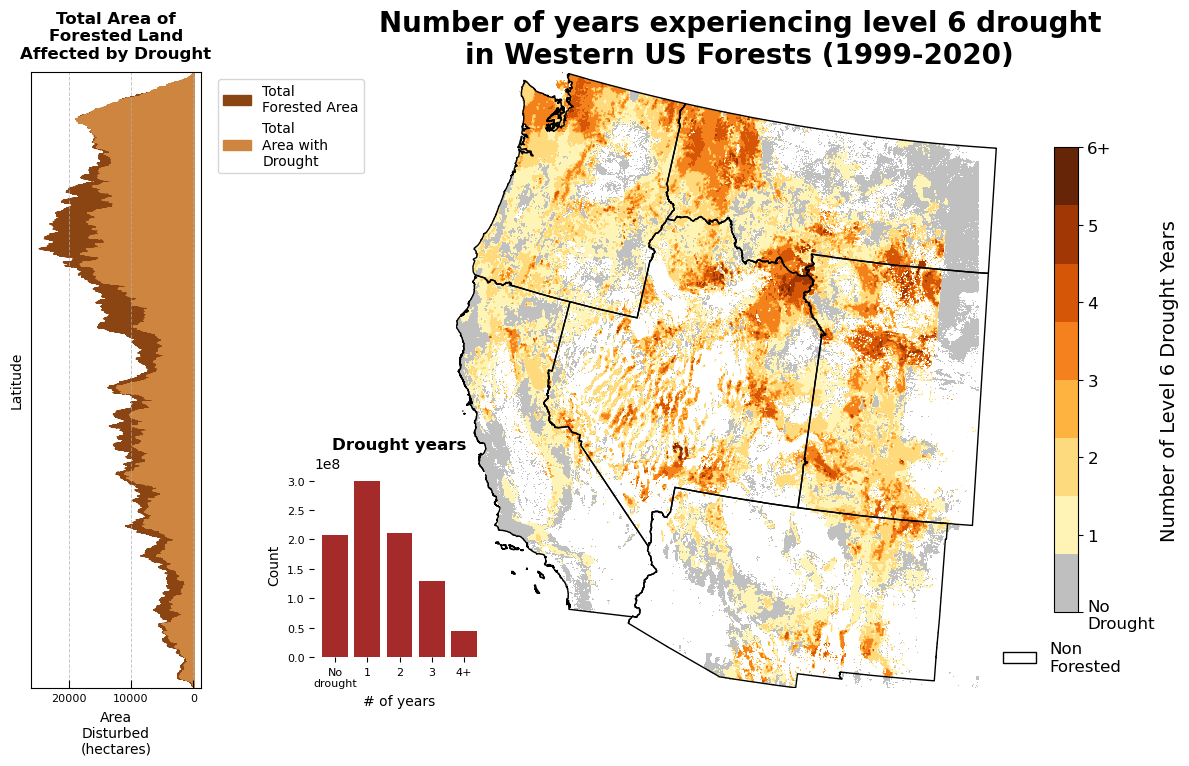

In [20]:
# Create cmap for the no data mask
my_cmap = cm.colors.ListedColormap(['white', 'none'])

# Create cmap for the drought data
YlOrBr = mpl.colormaps.get_cmap('YlOrBr')
newcolors = YlOrBr(np.linspace(0, 1, 8))
white = np.array([1, 1, 1, 0])  # Transparent white
black_half_transparent = np.array([0, 0, 0, 0.25])
newcolors = np.vstack((black_half_transparent, newcolors[1:, :]))
newcmp = ListedColormap(newcolors)

# Create a figure and axis with appropriate size for publication
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the drought array on the axis using the custom colormap
im = ax.imshow(aggregated_drought, cmap=newcmp, extent=drought_extent, vmin=0, vmax=6)
ax.imshow(aggregated_mask, cmap=my_cmap, 
          interpolation='none', 
          clim=[0.9, 1], extent=drought_extent)

# Overlay the boundary of the Western US EPA region
USFS_reproj.boundary.plot(ax=ax, color="black", linewidth=1)

# Customize axis properties for better appearance
ax.set_title("Number of years experiencing level 6 drought\nin Western US Forests (1999-2020)", fontsize=20, fontweight='bold')
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal', adjustable='box')  # Equal aspect ratio

# Add legend with appropriate labels
cbar = fig.colorbar(im, ax=ax, fraction=0.03, pad=0.04)
cbar.set_ticks(np.arange(0, 7))
cbar.set_ticklabels(["No\nDrought", "1", "2", "3", "4", "5", "6+"])
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Number of Level 6 Drought Years', fontsize=14)

legend_elements = [Patch(facecolor=white, edgecolor='black', label='Non\nForested')]
ax.legend(handles=legend_elements, bbox_to_anchor=(0.7, 0., 0.5, 0.1), fontsize=12, frameon=False)
ax.axis('off')

inset_ax = ax.inset_axes(bounds=(-0.25, 0.05, 0.3, 0.3), transform=ax.transAxes)
# Plot the bar plot in the inset axis
inset_ax.bar(list(range(5)), drought_amounts, color='brown')
inset_ax.set_title('Drought years', fontsize=12, fontweight='bold')
inset_ax.set_xlabel('# of years', fontsize=10)
inset_ax.set_ylabel('Count', fontsize=10)
inset_ax.tick_params(axis='both', which='major', labelsize=8)
inset_ax.spines['top'].set_visible(False)
inset_ax.spines['right'].set_visible(False)
inset_ax.spines['bottom'].set_visible(False)
inset_ax.spines['left'].set_visible(False)
inset_ax.set_xticks(list(range(5)))
inset_ax.set_xticklabels(drought_values)

ax_inset = ax.inset_axes(bounds=(-0.75, 0, .3, 1), transform=ax.transAxes)
# Plot the bar plot in the inset axis
ax_inset.fill_betweenx(drought_lat['Row'], 0, drought_lat['Total']*9/10, color='saddlebrown', label='Total\nForested Area')
ax_inset.fill_betweenx(drought_lat['Row'], 0, drought_lat['Count of 1s']*9/10, color='peru', label='Total\nArea with\nDrought')
ax_inset.legend(bbox_to_anchor=(2, 1))
ax_inset.set_title('Total Area of\nForested Land\nAffected by Drought', fontsize=12, fontweight='bold', pad=10)
ax_inset.set_xlabel('Area\nDisturbed\n(hectares)', fontsize=10, labelpad=5)
ax_inset.set_ylabel('Latitude', fontsize=10, labelpad=5)
ax_inset.tick_params(axis='both', which='major', labelsize=8)
ax_inset.tick_params(axis='x', direction='in', length=6)
ax_inset.tick_params(axis='y', direction='in', length=6)
ax_inset.invert_yaxis()
ax_inset.invert_xaxis()
ax_inset.set_yticks([])
ax_inset.set_ylim(drought_lat['Row'].max(), 0)
ax_inset.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# Save the plot as an image for publication
plt.savefig("drought_map.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()

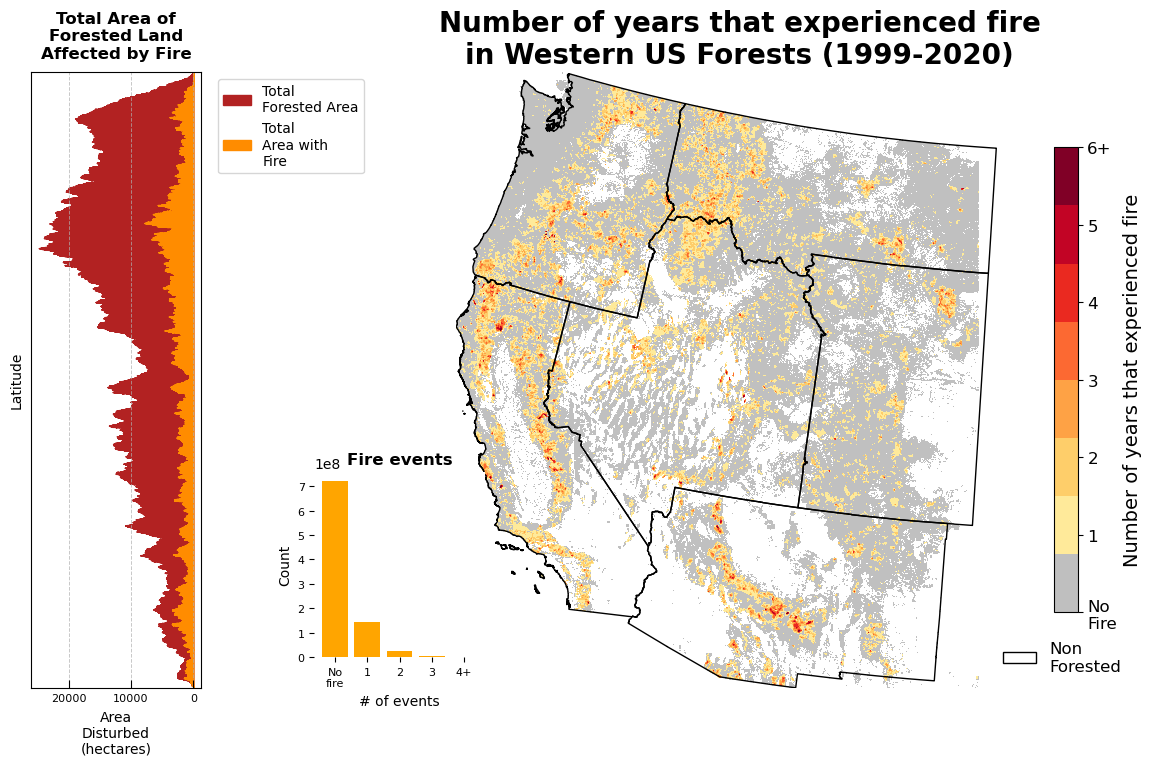

In [21]:
# Create cmap for the fire data
YlOrRd = mpl.colormaps['YlOrRd'].resampled(8)
newcolors = YlOrRd(np.linspace(0, 1, 8)) 
newcolors = np.vstack((black_half_transparent, newcolors[1:, :]))
newcmp = ListedColormap(newcolors)

fig, ax = plt.subplots(figsize=(10, 8))

# Plot the drought array on the axis using the custom colormap
im = ax.imshow(aggregated_fire, cmap=newcmp, extent=drought_extent, vmin=0, vmax=6)
ax.imshow(aggregated_mask, cmap=my_cmap, 
          interpolation='none', 
          clim=[0.9, 1], extent=drought_extent)

# Overlay the boundary of the Western US EPA region
USFS_reproj.boundary.plot(ax=ax, color="black", linewidth=1)

# Customize axis properties for better appearance
ax.set_title("Number of years that experienced fire\nin Western US Forests (1999-2020)", fontsize=20, fontweight='bold')
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal', adjustable='box')  # Equal aspect ratio

# Add legend with appropriate labels
cbar = fig.colorbar(im, ax=ax, fraction=0.03, pad=0.04)
cbar.set_ticks(np.arange(0, 7))
cbar.set_ticklabels(["No\nFire", "1", "2", "3", "4", "5", "6+"])
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Number of years that experienced fire', fontsize=14)

legend_elements = [Patch(facecolor=white, edgecolor='black', label='Non\nForested')]
ax.legend(handles=legend_elements, bbox_to_anchor=(0.7, 0., 0.5, 0.1), fontsize=12, frameon=False)
ax.axis('off')

inset_ax = ax.inset_axes(bounds=(-0.25, 0.05, 0.3, 0.3), transform=ax.transAxes)
# Plot the bar plot in the inset axis
inset_ax.bar(list(range(5)), fire_amounts, color='orange')
inset_ax.set_title('Fire events', fontsize=12, fontweight='bold')
inset_ax.set_xlabel('# of events', fontsize=10)
inset_ax.set_ylabel('Count', fontsize=10)
inset_ax.tick_params(axis='both', which='major', labelsize=8)
inset_ax.spines['top'].set_visible(False)
inset_ax.spines['right'].set_visible(False)
inset_ax.spines['bottom'].set_visible(False)
inset_ax.spines['left'].set_visible(False)
inset_ax.set_xticks(list(range(5)))
inset_ax.set_xticklabels(fire_values)

ax_inset = ax.inset_axes(bounds=(-0.75, 0, .3, 1), transform=ax.transAxes)
# Plot the bar plot in the inset axis
ax_inset.fill_betweenx(fire_lat['Row'], 0, fire_lat['Total']*9/10, color='firebrick', label='Total\nForested Area')
ax_inset.fill_betweenx(fire_lat['Row'], 0, fire_lat['Count of 1s']*9/10, color='darkorange', label='Total\nArea with\nFire')
ax_inset.legend(bbox_to_anchor=(2, 1))
ax_inset.set_title('Total Area of\nForested Land\nAffected by Fire', fontsize=12, fontweight='bold', pad=10)
ax_inset.set_xlabel('Area\nDisturbed\n(hectares)', fontsize=10, labelpad=5)
ax_inset.set_ylabel('Latitude', fontsize=10, labelpad=5)
ax_inset.tick_params(axis='both', which='major', labelsize=8)
ax_inset.tick_params(axis='x', direction='in', length=6)
ax_inset.tick_params(axis='y', direction='in', length=6)
ax_inset.invert_yaxis()
ax_inset.invert_xaxis()
ax_inset.set_yticks([])
ax_inset.set_ylim(fire_lat['Row'].max(), 0)

ax_inset.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# Save the plot as an image for publication
plt.savefig("fire_map.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()

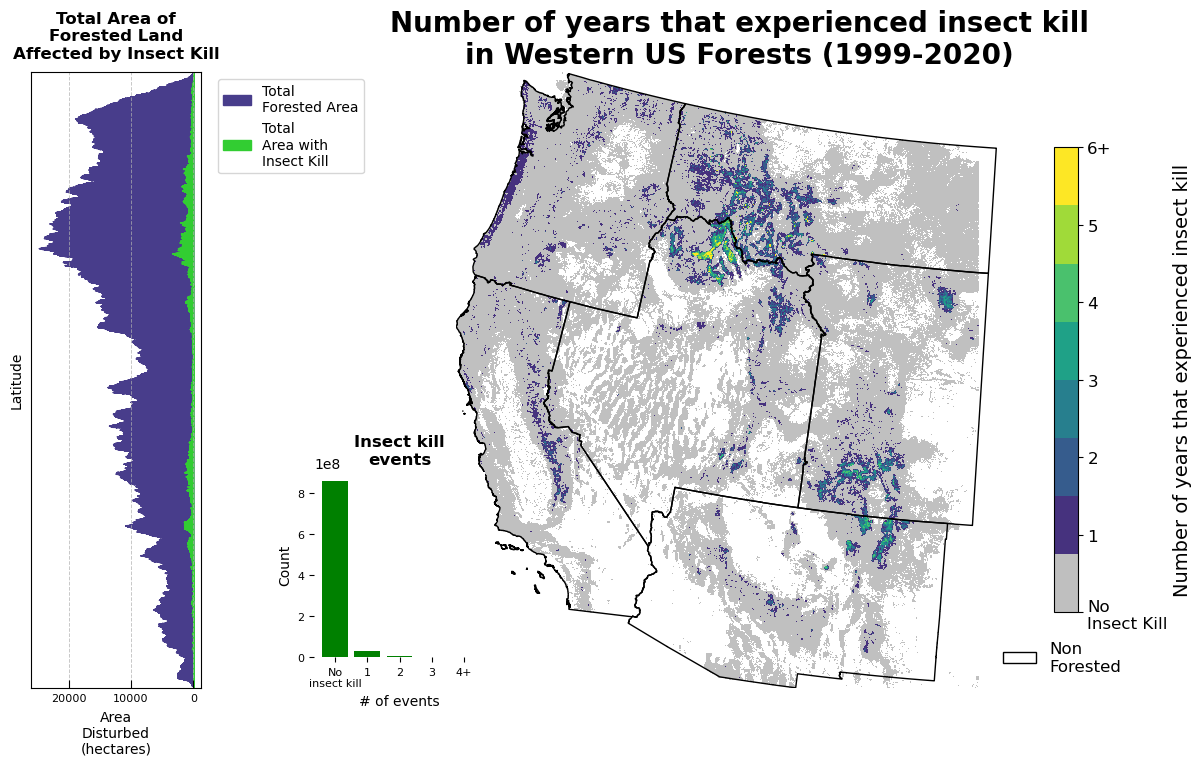

In [22]:
# Create cmap for beetle data
greens = mpl.colormaps['viridis'].resampled(8)
newcolors = greens(np.linspace(0, 1, 8)) 
newcolors = np.vstack((black_half_transparent, newcolors[1:, :]))
newcmp = ListedColormap(newcolors)

fig, ax = plt.subplots(figsize=(10, 8))

# Plot the drought array on the axis using the custom colormap
im = ax.imshow(aggregated_beetle, cmap=newcmp, extent=drought_extent, vmin=0, vmax=6)
ax.imshow(aggregated_mask, cmap=my_cmap, 
          interpolation='none', 
          clim=[0.9, 1], extent=drought_extent)

# Overlay the boundary of the Western US EPA region
USFS_reproj.boundary.plot(ax=ax, color="black", linewidth=1)

# Customize axis properties for better appearance
ax.set_title("Number of years that experienced insect kill\nin Western US Forests (1999-2020)", fontsize=20, fontweight='bold')
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal', adjustable='box')  # Equal aspect ratio

# Add legend with appropriate labels
cbar = fig.colorbar(im, ax=ax, fraction=0.03, pad=0.04)
cbar.set_ticks(np.arange(0, 7))
cbar.set_ticklabels(["No\nInsect Kill", "1", "2", "3", "4", "5", "6+"])
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Number of years that experienced insect kill', fontsize=14)

legend_elements = [Patch(facecolor=white, edgecolor='black', label='Non\nForested')]
ax.legend(handles=legend_elements, bbox_to_anchor=(0.7, 0., 0.5, 0.1), fontsize=12, frameon=False)
ax.axis('off')

inset_ax = ax.inset_axes(bounds=(-0.25, 0.05, 0.3, 0.3), transform=ax.transAxes)
# Plot the bar plot in the inset axis
inset_ax.bar(list(range(5)), beetle_amounts, color='green')
inset_ax.set_title('Insect kill\nevents', fontsize=12, fontweight='bold')
inset_ax.set_xlabel('# of events', fontsize=10)
inset_ax.set_ylabel('Count', fontsize=10)
inset_ax.tick_params(axis='both', which='major', labelsize=8)
inset_ax.spines['top'].set_visible(False)
inset_ax.spines['right'].set_visible(False)
inset_ax.spines['bottom'].set_visible(False)
inset_ax.spines['left'].set_visible(False)
inset_ax.set_xticks(list(range(5)))
inset_ax.set_xticklabels(beetle_values)

ax_inset = ax.inset_axes(bounds=(-0.75, 0, .3, 1), transform=ax.transAxes)
# Plot the bar plot in the inset axis
ax_inset.fill_betweenx(beetle_lat['Row'], 0, beetle_lat['Total']*9/10, color='darkslateblue', label='Total\nForested Area')
ax_inset.fill_betweenx(beetle_lat['Row'], 0, beetle_lat['Count of 1s']*9/10, color='limegreen', label='Total\nArea with\nInsect Kill')
ax_inset.legend(bbox_to_anchor=(2, 1))
ax_inset.set_title('Total Area of\nForested Land\nAffected by Insect Kill', fontsize=12, fontweight='bold', pad=10)
ax_inset.set_xlabel('Area\nDisturbed\n(hectares)', fontsize=10, labelpad=5)
ax_inset.set_ylabel('Latitude', fontsize=10, labelpad=5)
ax_inset.tick_params(axis='both', which='major', labelsize=8)
ax_inset.tick_params(axis='x', direction='in', length=6)
ax_inset.tick_params(axis='y', direction='in', length=6)
ax_inset.invert_yaxis()
ax_inset.invert_xaxis()
ax_inset.set_yticks([])
ax_inset.set_ylim(beetle_lat['Row'].max(), 0)

ax_inset.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# Save the plot as an image for publication
plt.savefig("beetle_map.png", dpi=300, bbox_inches='tight', transparent=True)

plt.show()


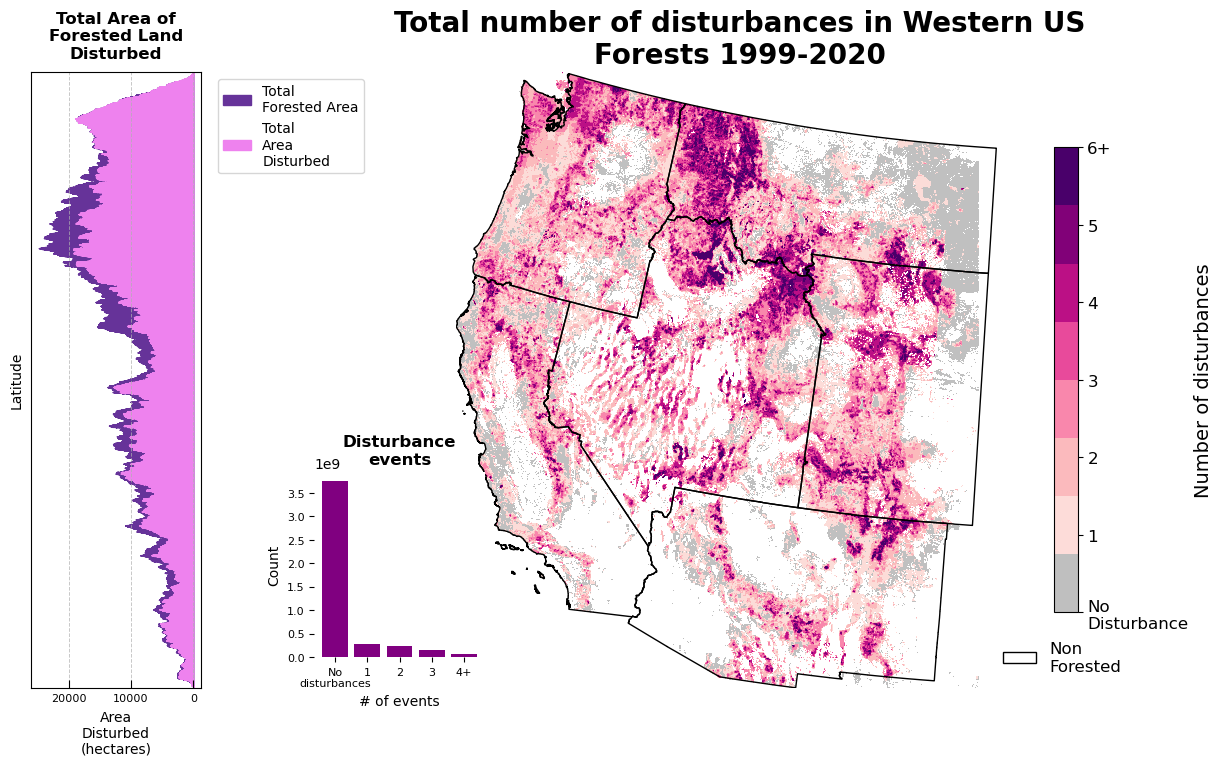

In [23]:
# Create cmap for all disturbance data
RdPu = mpl.colormaps['RdPu'].resampled(8)
newcolors = RdPu(np.linspace(0, 1, 8)) 
newcolors = np.vstack((black_half_transparent, newcolors[1:, :]))
newcmp = ListedColormap(newcolors)

fig, ax = plt.subplots(figsize=(10, 8))

# Plot the drought array on the axis using the custom colormap
im = ax.imshow(aggregated_all, cmap=newcmp, extent=all_extent, vmin=0, vmax=6)
ax.imshow(aggregated_mask, cmap=my_cmap, 
          interpolation='none', 
          clim=[0.9, 1], extent=drought_extent)

# Overlay the boundary of the Western US EPA region
USFS_reproj.boundary.plot(ax=ax, color="black", linewidth=1)

# Customize axis properties for better appearance
ax.set_title("Total number of disturbances in Western US\nForests 1999-2020", fontsize=20, fontweight='bold')
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal', adjustable='box')  # Equal aspect ratio

# Add legend with appropriate labels
cbar = fig.colorbar(im, ax=ax, fraction=0.03, pad=0.04)
cbar.set_ticks(np.arange(0, 7))
cbar.set_ticklabels(["No\nDisturbance", "1", "2", "3", "4", "5", "6+"])
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Number of disturbances', fontsize=14)

legend_elements = [Patch(facecolor=white, edgecolor='black', label='Non\nForested')]
ax.legend(handles=legend_elements, bbox_to_anchor=(0.7, 0., 0.5, 0.1), fontsize=12, frameon=False)
ax.axis('off')

inset_ax = ax.inset_axes(bounds=(-0.25, 0.05, 0.3, 0.3), transform=ax.transAxes)
# Plot the bar plot in the inset axis
inset_ax.bar(list(range(5)), all_amounts, color='purple')
inset_ax.set_title('Disturbance\nevents', fontsize=12, fontweight='bold')
inset_ax.set_xlabel('# of events', fontsize=10)
inset_ax.set_ylabel('Count', fontsize=10)
inset_ax.tick_params(axis='both', which='major', labelsize=8)
inset_ax.spines['top'].set_visible(False)
inset_ax.spines['right'].set_visible(False)
inset_ax.spines['bottom'].set_visible(False)
inset_ax.spines['left'].set_visible(False)
inset_ax.set_xticks(list(range(5)))
inset_ax.set_xticklabels(all_values)

ax_inset = ax.inset_axes(bounds=(-0.75, 0, .3, 1), transform=ax.transAxes)
# Plot the bar plot in the inset axis
ax_inset.fill_betweenx(beetle_lat['Row'], 0, beetle_lat['Total']*9/10, color='rebeccapurple', label='Total\nForested Area')
ax_inset.fill_betweenx(all_lat['Row'], 0, all_lat['Count of 1s']*9/10, color='violet', label='Total\nArea\nDisturbed')
ax_inset.legend(bbox_to_anchor=(2, 1))
ax_inset.set_title('Total Area of\nForested Land\nDisturbed', fontsize=12, fontweight='bold', pad=10)
ax_inset.set_xlabel('Area\nDisturbed\n(hectares)', fontsize=10, labelpad=5)
ax_inset.set_ylabel('Latitude', fontsize=10, labelpad=5)
ax_inset.tick_params(axis='both', which='major', labelsize=8)
ax_inset.tick_params(axis='x', direction='in', length=6)
ax_inset.tick_params(axis='y', direction='in', length=6)
ax_inset.invert_yaxis()
ax_inset.invert_xaxis()
ax_inset.set_yticks([])
ax_inset.set_ylim(all_lat['Row'].max(), 0)

ax_inset.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# Save the plot as an image for publication
plt.savefig("all_image.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()


In [ ]:
# Change color schemes
# Create beetle/fire map
# Difference between total & beetle/fire